### Used Language : Python3

# Downloading MNIST

Reference:  
https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py  
https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/dataset/mnist.py 

In [1]:
import numpy as np
import os
import urllib.request
import gzip

In [2]:

img_size = 784

def load_dataset():

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urllib.request.urlretrieve(source + filename, filename)

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        
        data = data.reshape(-1, img_size)
        
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
            
        return data
    
    def _change_one_hot_label(X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1
        
        return T

    
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
    
    y_train = _change_one_hot_label(y_train)
    y_test =  _change_one_hot_label(y_test)

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

# Implementing 3 layer Neural Network  
Reference :   
https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch04/two_layer_net.py  
https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch04/train_neuralnet.py  


In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_diff(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    
    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))
    
def cross_entropy_error(y, t):
    if y.ndim == 1:   
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


class Three_Layer_NN:
    
    def __init__(self, input_size, hidden_1_size, hidden_2_size, output_size, std=0.01):
        
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_1_size)
        self.params['b1'] = np.zeros(hidden_1_size)
        self.params['W2'] = std * np.random.randn(hidden_1_size, hidden_2_size)
        self.params['b2'] = np.zeros(hidden_2_size)
        self.params['W3'] = std * np.random.randn(hidden_2_size, output_size)
        self.params['b3'] = np.zeros(output_size)
    
    
    def loss(self, X, t=None):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']
        
        
        # forward
        U1 = np.dot(X, W1) + b1    
        Z1 = sigmoid(U1)           
        U2 = np.dot(Z1, W2) + b2
        Z2 = sigmoid(U2)
        U3 = np.dot(Z2, W3) + b3
        y = softmax(U3)     
                
        if t is None:
            return y
        
        # loss function
        loss = cross_entropy_error(y, t)    
        
        # back propagation
        grads = {}
        batch_num = X.shape[0]
        
        delta_3 = (y - t) / batch_num        
        grads['W3'] = np.dot(Z2.T, delta_3)
        grads['b3'] = np.sum(delta_3, axis=0)
        
        delta_2 = (np.dot(delta_3, W3.T)) * sigmoid_diff(U2)
        grads['W2'] = np.dot(Z1.T, delta_2)
        grads['b2'] = np.sum(delta_2, axis=0)
        
        delta_1 = (np.dot(delta_2, W2.T)) * sigmoid_diff(U1)
        grads['W1'] = np.dot(X.T, delta_1)
        grads['b1'] = np.sum(delta_1, axis=0)
        
        return loss, grads
    
    # Training by SGD
    def train(self, X, t, X_val, y_val, learning_rate=0.1, num_iters=10000, batch_size=100):
        
        train_acc_list = []
        val_acc_list = []
        
        iter_per_epoch = 500
        
        for i in range(num_iters):
            batch = np.random.choice(X.shape[0], batch_size)
            X_batch = X[batch]
            t_batch = t[batch]
            
            loss, grads = self.loss(X_batch, t_batch)
            
            for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
                self.params[key] -= learning_rate * grads[key] 
            
            if i % iter_per_epoch == 0:
                train_acc = self.accuracy(X, t)
                val_acc = self.accuracy(X_val, y_val)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                print(i, ": train acc, val acc | " + str(train_acc) + ", " + str(val_acc))
                
        print("Finish!")
        return train_acc_list, val_acc_list
            
    
    def predict(self, X):    
        return self.loss(X)
    
    def accuracy(self, X, t):
        y = self.predict(X)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(X.shape[0])
        return accuracy
        

# Feeding the data and Checking the accuracy 

In [13]:
# Learnig rate : 0.1
# Iteration : 10000
# Batch size : 100
network = Three_Layer_NN(input_size=784, hidden_1_size=255, hidden_2_size=75, 
                         output_size=10, std=0.01)

_, _ = network.train(X_train, y_train, X_val, y_val, learning_rate=0.1, num_iters=10000, batch_size=100)

0 : train acc, val acc | 0.09936, 0.099
500 : train acc, val acc | 0.1035, 0.109
1000 : train acc, val acc | 0.11356, 0.1064
1500 : train acc, val acc | 0.10202, 0.103
2000 : train acc, val acc | 0.11356, 0.1064
2500 : train acc, val acc | 0.20926, 0.2156
3000 : train acc, val acc | 0.36348, 0.3705
3500 : train acc, val acc | 0.53948, 0.5647
4000 : train acc, val acc | 0.65386, 0.6774
4500 : train acc, val acc | 0.75854, 0.7908
5000 : train acc, val acc | 0.79964, 0.823
5500 : train acc, val acc | 0.81998, 0.8345
6000 : train acc, val acc | 0.84584, 0.857
6500 : train acc, val acc | 0.8597, 0.8668
7000 : train acc, val acc | 0.87174, 0.8778
7500 : train acc, val acc | 0.8785, 0.8836
8000 : train acc, val acc | 0.88868, 0.8936
8500 : train acc, val acc | 0.89548, 0.9011
9000 : train acc, val acc | 0.90386, 0.9073
9500 : train acc, val acc | 0.90818, 0.912
Finish!


In [14]:
network.accuracy(X_test, y_test)

0.91249999999999998

In [15]:
# Learnig rate : 1.1
# Iteration : 5000
# Batch size : 100
network = Three_Layer_NN(input_size=784, hidden_1_size=255, hidden_2_size=75, 
                         output_size=10, std=0.01)

_, _ = network.train(X_train, y_train, X_val, y_val, learning_rate=1.1, num_iters=5000, batch_size=100)

0 : train acc, val acc | 0.11356, 0.1064
500 : train acc, val acc | 0.39774, 0.3863
1000 : train acc, val acc | 0.85136, 0.8626
1500 : train acc, val acc | 0.92042, 0.9254
2000 : train acc, val acc | 0.93692, 0.9422
2500 : train acc, val acc | 0.95314, 0.9526
3000 : train acc, val acc | 0.96066, 0.9605
3500 : train acc, val acc | 0.96656, 0.9631
4000 : train acc, val acc | 0.97092, 0.9663
4500 : train acc, val acc | 0.97664, 0.9683
Finish!


In [16]:
network.accuracy(X_test, y_test)

0.96999999999999997

# Option 

## Hyper parameter tuning : Learning rate

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Iteration : 10000
# batch size : 100

# 0.1 ~ 0.9
val_acc_list_decimal = []
for lr in np.arange(0.1, 1.0, 0.1):
    print("learnig rate :", lr)
    network = Three_Layer_NN(input_size=784, hidden_1_size=255, hidden_2_size=75, 
                         output_size=10, std=0.01)
    _, val_acc_list = network.train(X_train, y_train, X_val, y_val, 
                                       learning_rate=lr, num_iters=10000, batch_size=100)
    val_acc_list_decimal.append(val_acc_list)
    print("lr =",lr, ": accuracy (test)", network.accuracy(X_test, y_test))

learnig rate : 0.1
0 : train acc, val acc | 0.1035, 0.109
500 : train acc, val acc | 0.11356, 0.1064
1000 : train acc, val acc | 0.11356, 0.1064
1500 : train acc, val acc | 0.11356, 0.1064
2000 : train acc, val acc | 0.10202, 0.103
2500 : train acc, val acc | 0.22418, 0.219
3000 : train acc, val acc | 0.36874, 0.3726
3500 : train acc, val acc | 0.53864, 0.5546
4000 : train acc, val acc | 0.6162, 0.6393
4500 : train acc, val acc | 0.72974, 0.7578
5000 : train acc, val acc | 0.7804, 0.804
5500 : train acc, val acc | 0.80946, 0.8249
6000 : train acc, val acc | 0.836, 0.8485
6500 : train acc, val acc | 0.85326, 0.8612
7000 : train acc, val acc | 0.86706, 0.8737
7500 : train acc, val acc | 0.87866, 0.8843
8000 : train acc, val acc | 0.88568, 0.8909
8500 : train acc, val acc | 0.8964, 0.9017
9000 : train acc, val acc | 0.90234, 0.9082
9500 : train acc, val acc | 0.90586, 0.9111
Finish!
lr = 0.1 : accuracy (test) 0.9136
learnig rate : 0.2
0 : train acc, val acc | 0.10202, 0.103
500 : train ac

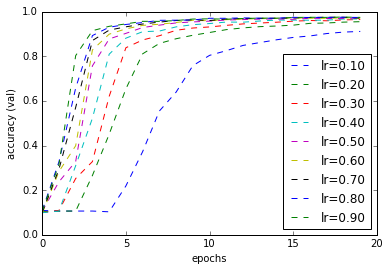

In [8]:
i = 0.1
for val_acc_list in val_acc_list_decimal:
    x = np.arange(len(val_acc_list))
    
    plt.plot(x, val_acc_list, label='lr=%0.2f' % i, linestyle='--')
    plt.xlabel("epochs")
    plt.ylabel("accuracy (val)")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    i += 0.1

In [17]:
# iteration : 5000
# batch size : 100

# 1.0 ~ 10.0
val_acc_list_int = []
for lr in np.arange(1.0, 11.0, 1):
    print("learnig rate :", lr)
    network = Three_Layer_NN(input_size=784, hidden_1_size=255, hidden_2_size=75, 
                         output_size=10, std=0.01)
    _, val_acc_list = network.train(X_train, y_train, X_val, y_val, 
                                       learning_rate=lr, num_iters=5000, batch_size=100)
    val_acc_list_int.append(val_acc_list)
    print("lr =",lr, ": accuracy (test)", network.accuracy(X_test, y_test))


learnig rate : 1.0
0 : train acc, val acc | 0.09936, 0.099
500 : train acc, val acc | 0.34782, 0.3453
1000 : train acc, val acc | 0.84774, 0.8566
1500 : train acc, val acc | 0.9164, 0.923
2000 : train acc, val acc | 0.93726, 0.9434
2500 : train acc, val acc | 0.94682, 0.9491
3000 : train acc, val acc | 0.94958, 0.9503
3500 : train acc, val acc | 0.96672, 0.9651
4000 : train acc, val acc | 0.96986, 0.966
4500 : train acc, val acc | 0.97506, 0.9684
Finish!
lr = 1.0 : accuracy (test) 0.9665
learnig rate : 2.0
0 : train acc, val acc | 0.1035, 0.109
500 : train acc, val acc | 0.59982, 0.6145
1000 : train acc, val acc | 0.92354, 0.9288
1500 : train acc, val acc | 0.94424, 0.9472
2000 : train acc, val acc | 0.95648, 0.9555
2500 : train acc, val acc | 0.96668, 0.9613
3000 : train acc, val acc | 0.97626, 0.9696
3500 : train acc, val acc | 0.98106, 0.9713
4000 : train acc, val acc | 0.9835, 0.9722
4500 : train acc, val acc | 0.98364, 0.9711
Finish!
lr = 2.0 : accuracy (test) 0.9712
learnig rate 

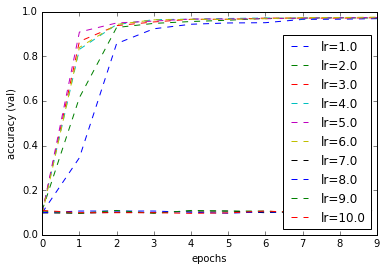

In [20]:
i = 1
for val_acc_list in val_acc_list_int:
    x = np.arange(len(val_acc_list))
    
    plt.plot(x, val_acc_list, label='lr=%0.1f' % i, linestyle='--')
    plt.xlabel("epochs")
    plt.ylabel("accuracy (val)")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    i += 1

## Hyper parameter tuning : Batch size

In [24]:
val_acc_list_batch = []
for batch in np.arange(50, 175, 25):
    print("Batch size :", batch)
    network = Three_Layer_NN(input_size=784, hidden_1_size=255, hidden_2_size=75, 
                         output_size=10, std=0.01)
    _, val_acc_list = network.train(X_train, y_train, X_val, y_val, 
                                       learning_rate=5.0, num_iters=5000, batch_size=batch)
    val_acc_list_batch.append(val_acc_list)
    print("Batch size =", batch, ": accuracy (test)", network.accuracy(X_test, y_test))
    

Batch size : 50
0 : train acc, val acc | 0.1035, 0.109
500 : train acc, val acc | 0.11356, 0.1064
1000 : train acc, val acc | 0.11356, 0.1064
1500 : train acc, val acc | 0.10202, 0.103
2000 : train acc, val acc | 0.33766, 0.3487
2500 : train acc, val acc | 0.9125, 0.9175
3000 : train acc, val acc | 0.90824, 0.9142
3500 : train acc, val acc | 0.9383, 0.9373
4000 : train acc, val acc | 0.95182, 0.9526
4500 : train acc, val acc | 0.95538, 0.9534
Finish!
Batch size = 50 : accuracy (test) 0.9531
Batch size : 75
0 : train acc, val acc | 0.09864, 0.0991
500 : train acc, val acc | 0.1035, 0.109
1000 : train acc, val acc | 0.59856, 0.6037
1500 : train acc, val acc | 0.91672, 0.9187
2000 : train acc, val acc | 0.95778, 0.9579
2500 : train acc, val acc | 0.95858, 0.9516
3000 : train acc, val acc | 0.97148, 0.9646
3500 : train acc, val acc | 0.97474, 0.9658
4000 : train acc, val acc | 0.97626, 0.9665
4500 : train acc, val acc | 0.98306, 0.9704
Finish!
Batch size = 75 : accuracy (test) 0.969
Batch 

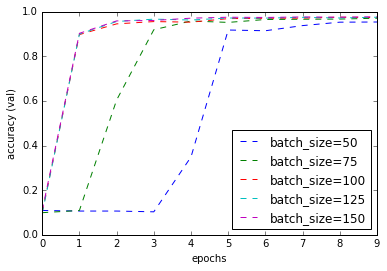

In [26]:
i = 50
for val_acc_list in val_acc_list_batch:
    x = np.arange(len(val_acc_list))
    
    plt.plot(x, val_acc_list, label='batch_size=%d' % i, linestyle='--')
    plt.xlabel("epochs")
    plt.ylabel("accuracy (val)")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    i += 25

In [7]:
network = Three_Layer_NN(input_size=784, hidden_1_size=255, hidden_2_size=75, 
                         output_size=10, std=0.01)

_, _ = network.train(X_train, y_train, X_val, y_val, learning_rate=5.0, num_iters=6000, batch_size=100)

0 : train acc, val acc | 0.09902, 0.0967
500 : train acc, val acc | 0.89538, 0.9035
1000 : train acc, val acc | 0.94722, 0.9467
1500 : train acc, val acc | 0.96152, 0.958
2000 : train acc, val acc | 0.97278, 0.9654
2500 : train acc, val acc | 0.97848, 0.9695
3000 : train acc, val acc | 0.97566, 0.9641
3500 : train acc, val acc | 0.98554, 0.9724
4000 : train acc, val acc | 0.98924, 0.9726
4500 : train acc, val acc | 0.98936, 0.9738
5000 : train acc, val acc | 0.99214, 0.9735
5500 : train acc, val acc | 0.99386, 0.9752
Finish!


In [8]:
network.accuracy(X_test, y_test)

0.97199999999999998